In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../")

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from model import build_model
from clip_ import load, tokenize, similarity_score
from vit_cam import interpret_vit, interpret_vit_overlapped

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model_vit, preprocess = load("ViT-B/32", device=device, jit=False)

In [4]:
font = {
    'size': 35,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])
root = "../../Images/"

## Text-Image

In [5]:
res_dir = "../../results/method_compariosn/txt_image/"

if not os.path.exists(res_dir):
    os.mkdir(res_dir)
    
img_ids = ["horse&dog.jpg", "horse&sheep.jpg", "cow&sheep.jpg"]#, "vase_or_face.png", "duck-rabbit.jpeg"]

text_lists = [["a horse", "a dog"],
              ["a horse", "a sheep"],
              ["a cow", "a sheep"],
             ]


/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


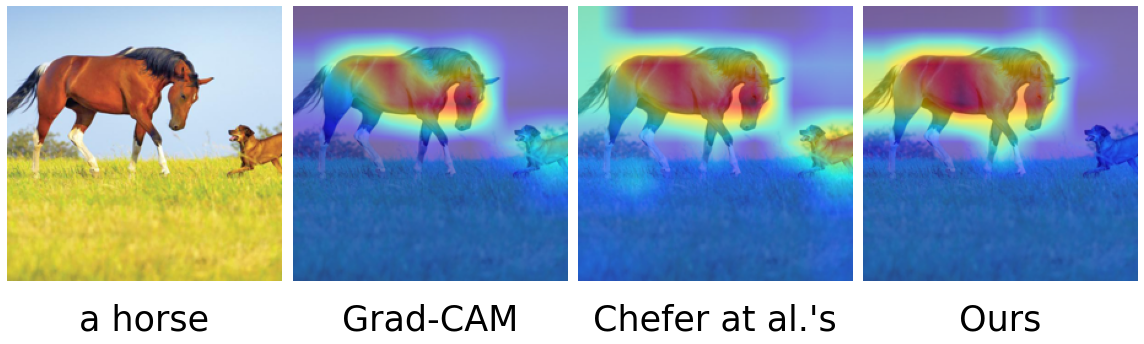

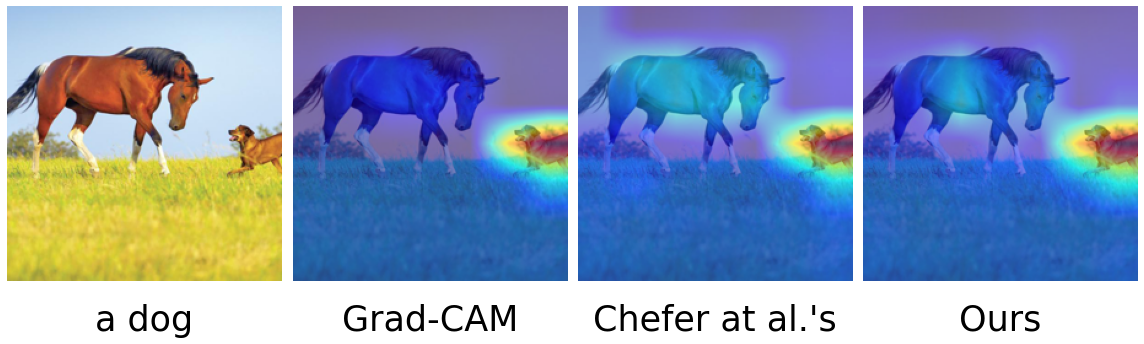

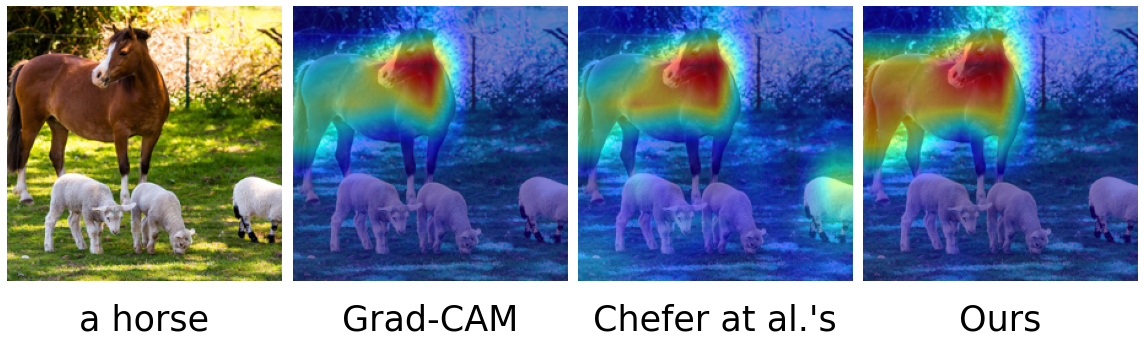

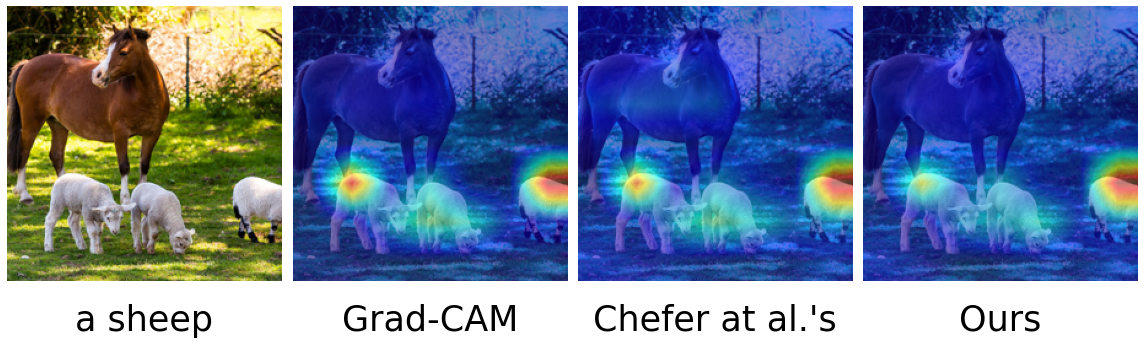

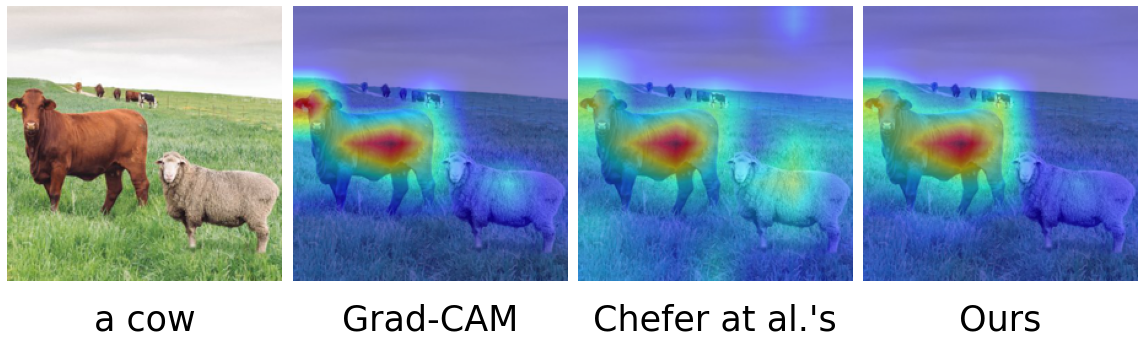

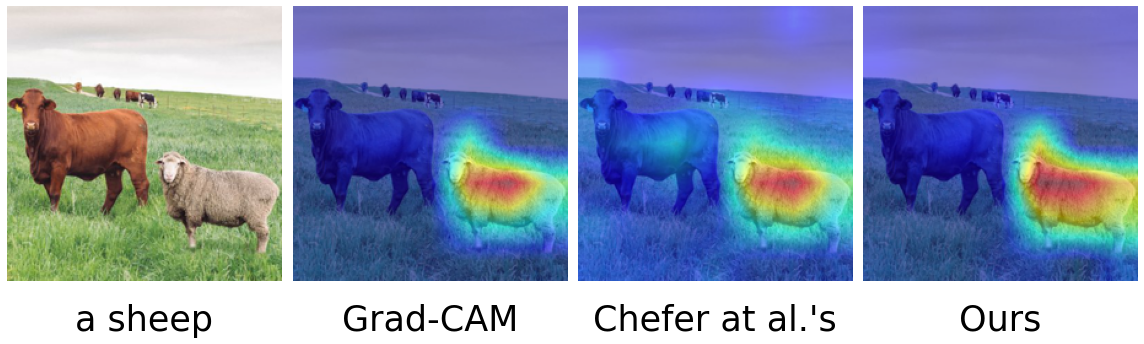

In [6]:
pp = PdfPages(res_dir + 'all.pdf')
#fig, ax = plt.subplots(len(2*img_ids), 3, figsize=(16,16))

for id_, img_id in enumerate(img_ids):
    
    texts = text_lists[id_]
    
    for t_id, text in enumerate(texts):
        
        t_text = tokenize(text).to(device)
        text_features = model_vit.encode_text(t_text)
        
        img_path =  os.path.join(root, img_id )
        image = ori_preprocess(Image.open(img_path))
        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        plt.figure(figsize=(16, 16))
        plt.tight_layout()
        plt.subplot(141)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis('off')
        plt.title(text, **font, y=-0.20)


        subplot = 142
        
        for method_id, method in enumerate(["gradcam", "all grads", "last grad"]):
            
            if method=="gradcam":
                title = "Grad-CAM"
            elif method=="all grads":
                title = "Chefer at al.'s"
            else:
                title = "Ours"
    
            plt.subplot(subplot+method_id)
            interpret_vit(p_image.type(model_vit.dtype), text_features, model_vit.visual, device, method=method)
            plt.axis('off')
            plt.title(title, **font,y=-0.20)
            plt.tight_layout()
                
        plt.savefig(res_dir+f"{text}_{img_id}")   
        pp.savefig()
        
pp.close()

## Image-Image

In [9]:
res_dir = "../../results/method_compariosn/img_img/"

if not os.path.exists(res_dir):
    os.mkdir(res_dir)
    
img1_ids = ["horse&dog.jpg", "horse&sheep.jpg", "cow&sheep.jpg"]

img2_ids = [["horse.jpg", "dog.jpg", "horse_sketch.jpg", "dog_sketch.jpg"], 
            ["horse.jpg", "sheep.jpg", "horse_comic.jpg", "sheep_comic.jpg"], 
            ["cow.jpg", "sheep.jpg", "cow_comic.jpg", "sheep_comic.jpg"], 
           ]

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


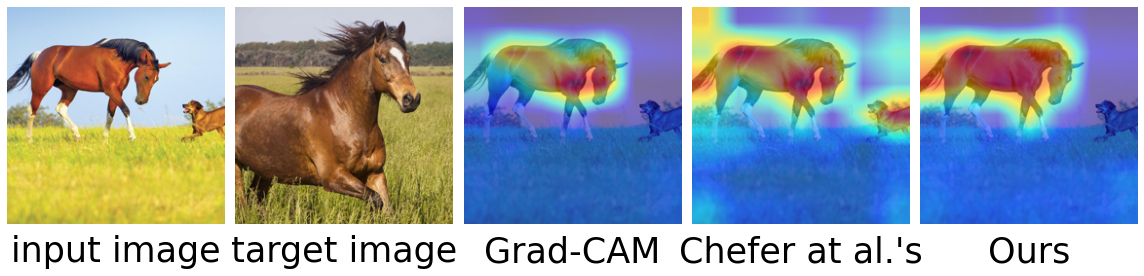

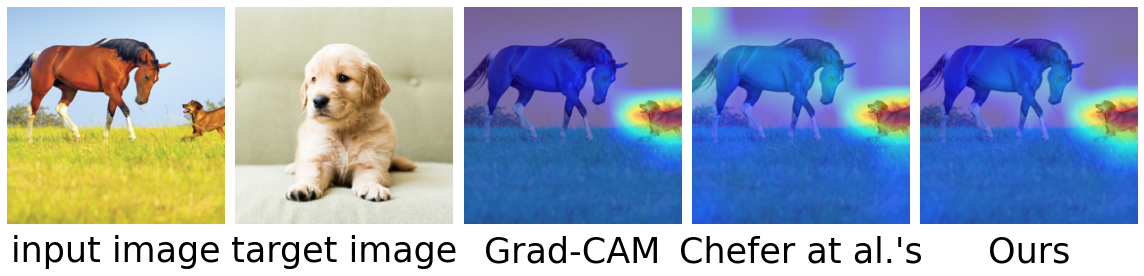

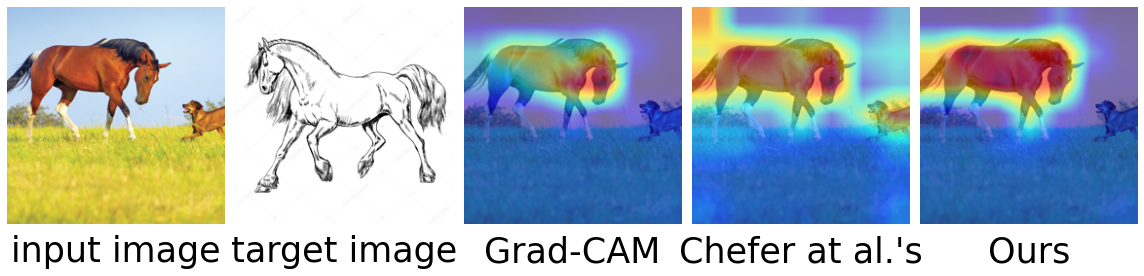

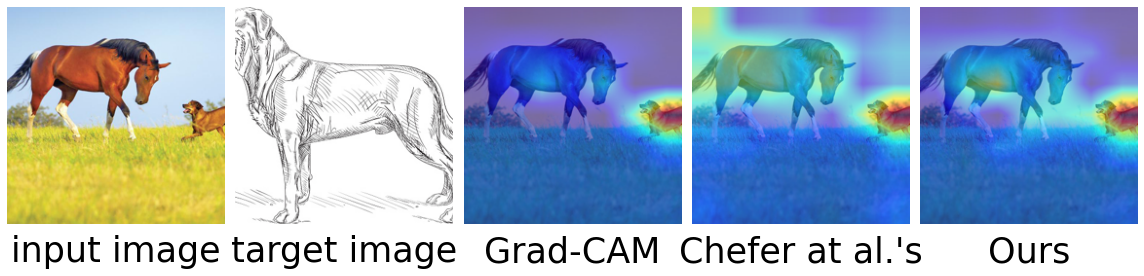

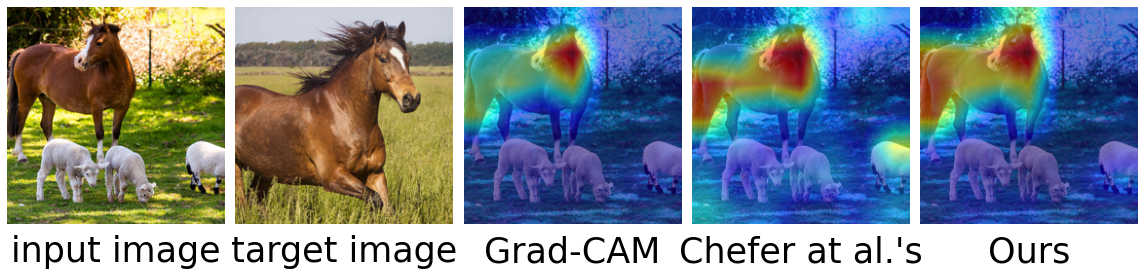

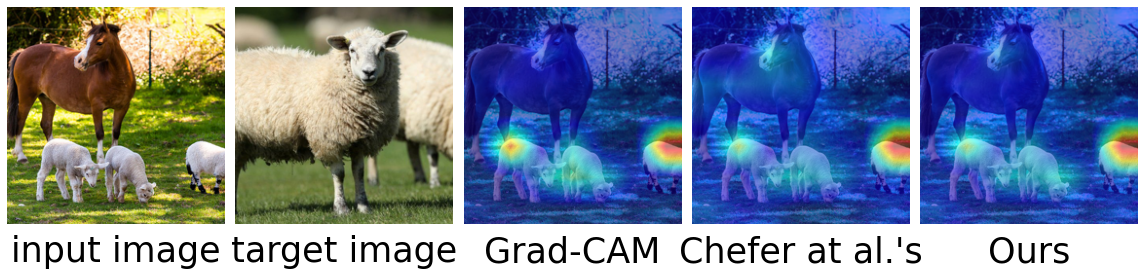

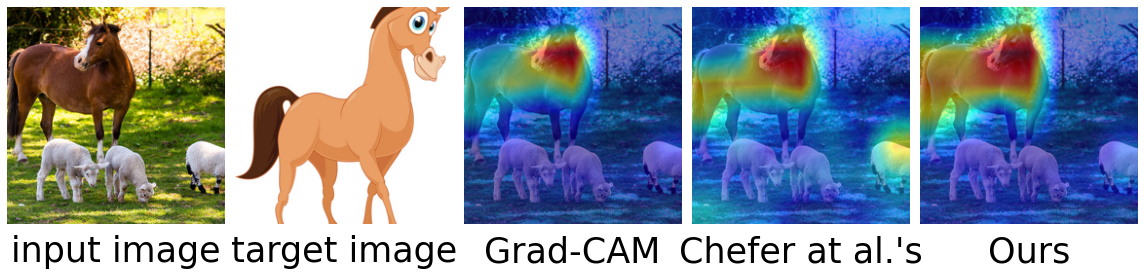

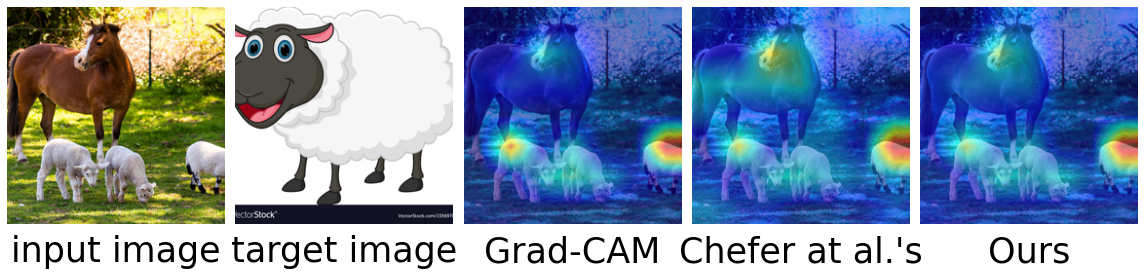

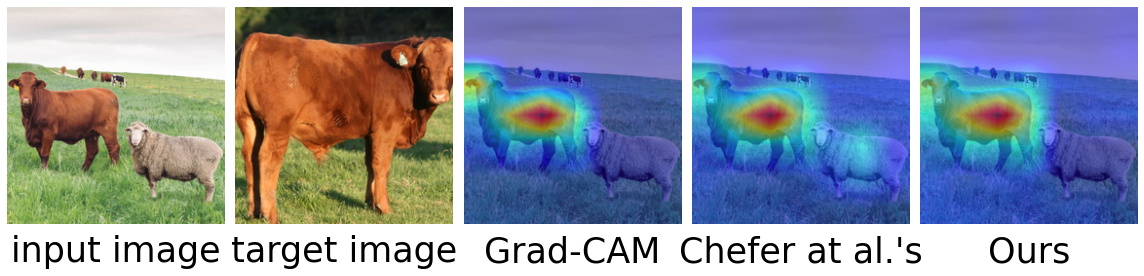

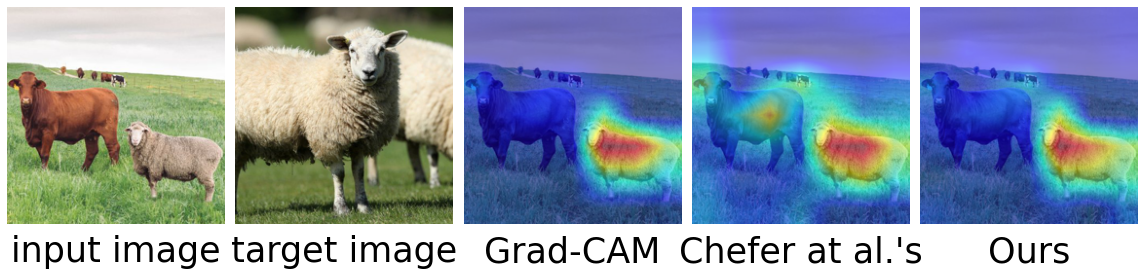

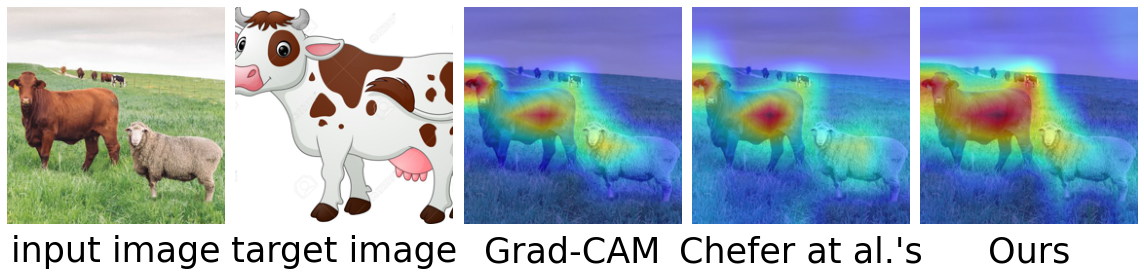

In [ ]:
pp = PdfPages(res_dir + 'all.pdf')

for id1, img1_id in enumerate(img1_ids):
    imgs = img2_ids[id1]
    for id2,img2_id in enumerate(imgs):
        
        img1_path =  os.path.join(root, img1_id)
        image1 = ori_preprocess(Image.open(img1_path))
        p_image1 = preprocess(Image.open(img1_path)).unsqueeze(0).to(device)
        
        img2_path =  os.path.join(root, img2_id)
        image2 = ori_preprocess(Image.open(img2_path))
        p_image2 = preprocess(Image.open(img2_path)).unsqueeze(0).to(device)
        
        target_features = model_vit.encode_image(p_image2)
        target_features = target_features.detach()
      
        plt.figure(figsize=(16, 16))
        
        plt.subplot(151)
        plt.axis('off')
        plt.imshow(image1.permute(1, 2, 0))
        plt.title("input image", **font, y=-0.20)

        
        plt.subplot(152)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(image2.permute(1, 2, 0))
        plt.title("target image", **font, y=-0.20)
        


            
        for method_id, method in enumerate(["gradcam", "all grads", "last grad"]):
            
            if method=="gradcam":
                title = "Grad-CAM"
            elif method=="all grads":
                title = "Chefer at al.'s"
            else:
                title = "Ours"
                

            plt.subplot(153+method_id)
            plt.axis('off')
            plt.tight_layout()
            interpret_vit(p_image1.type(model_vit.dtype), target_features, model_vit.visual, device, method=method)
            plt.title(title, **font,y=-0.20)
           
        
        plt.savefig(res_dir+f"{img2_id[:-4]}_{img1_id}")  
        pp.savefig()
        
pp.close()              